In [2]:
import polars as pl
import plotly.express as px
import sys
import logging
from pathlib import Path
from IPython.display import display

# --- Setup Project Path ---
# This ensures we can import from our quandex_core package
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# --- Import the Singleton Config ---
# This is the key to integration. We use the globally managed config and its resources.
from quandex_core.config import config
logger = logging.getLogger(__name__)

print("Bharat QuanDex Notebook Environment Initialized")
print(f"Using database: {config.data.duckdb_path}")

Bharat QuanDex Notebook Environment Initialized
Using database: D:\bharat_quandex\data_vault\market_boards\quandex.duckdb


2025-06-14 01:18:06 | INFO     | Starting analysis...
2025-06-14 01:18:06 | INFO     | Executing query for RELIANCE.NS and TCS.NS...
2025-06-14 01:18:06 | INFO     | Successfully retrieved 48 records.



--- Data Preview ---


symbol,date,open,high,low,close,volume,sma_50,rsi_14
str,date,f32,f32,f32,f32,i64,f64,f64
"""TCS.NS""",2025-05-13,3620.399902,3623.0,3510.5,3515.0,3062887,3515.0,null
"""RELIANCE.NS""",2025-05-13,1433.5,1447.699951,1412.400024,1415.699951,11407896,1415.699951,null
"""TCS.NS""",2025-05-14,3521.0,3561.0,3508.600098,3548.699951,2119499,3531.849976,null
"""RELIANCE.NS""",2025-05-14,1420.0,1429.900024,1415.5,1424.400024,5570160,1420.049988,null
"""TCS.NS""",2025-05-15,3564.0,3600.0,3514.100098,3579.899902,3548330,3547.866618,null



--- Price Chart ---


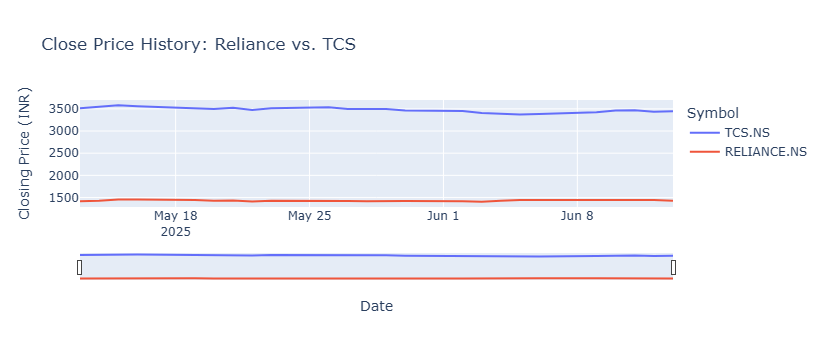

In [3]:
# --- Main Analysis Block ---
logger.info("Starting analysis...")

try:
    # Use the shared connection from our global config object
    conn = config.data.conn
    
    # --- 1. Database Query ---
    # Query the processed data table directly.
    query = """
    SELECT
        symbol, date, open, high, low, close, volume, sma_50, rsi_14
    FROM processed_equity_data
    WHERE symbol IN (?, ?)
    ORDER BY date
    """
    
    logger.info("Executing query for RELIANCE.NS and TCS.NS...")
    results_df = conn.execute(query, ['RELIANCE.NS', 'TCS.NS']).pl()

    if results_df.is_empty():
        logger.error("Query returned no data! Please run the full_refresh in the fetcher first.")
    else:
        logger.info(f"Successfully retrieved {results_df.height} records.")
        
        # --- 2. Display Data Preview ---
        print("\n--- Data Preview ---")
        display(results_df.head())
        
        # --- 3. Create Visualization ---
        print("\n--- Price Chart ---")
        pandas_df = results_df.to_pandas()
        fig = px.line(
            pandas_df, x='date', y='close', color='symbol',
            title='Close Price History: Reliance vs. TCS',
            labels={'date': 'Date', 'close': 'Closing Price (INR)'}
        )
        fig.update_layout(legend_title='Symbol', hovermode='x unified')
        fig.update_xaxes(rangeslider_visible=True)
        fig.show()

except Exception as e:
    logger.exception("An error occurred during analysis:")

In [5]:
# Cell 3: Summary Statistics & Correlation Analysis

# --- Deeper Analysis ---
if not results_df.is_empty():
    # --- 1. Summary Statistics ---
    print("\n--- Summary Statistics ---")
    summary_df = results_df.group_by("symbol").agg([
        pl.col("close").count().alias("record_count"),
        pl.col("date").min().alias("start_date"),
        pl.col("date").max().alias("end_date"),
        pl.col("close").mean().alias("avg_close"),
        pl.col("close").std().alias("volatility"),
        pl.col("volume").mean().alias("avg_volume")
    ])
    display(summary_df)

    # --- 2. Correlation Analysis ---
    print("\n--- Price Correlation Matrix ---")
    pivoted_df = results_df.pivot(
        index="date",
        columns="symbol",
        values="close"
    ).drop_nulls()

    # for the correlation matrix calculation. We select all columns
    # except the 'date' column.
    correlation_matrix = pivoted_df.select(
        pl.all().exclude("date")
    ).corr()
    # -----------------------
    
    display(correlation_matrix)
    
else:
    logger.warning("Skipping deeper analysis as no data was loaded in the previous step.")


--- Summary Statistics ---


symbol,record_count,start_date,end_date,avg_close,volatility,avg_volume
str,u32,date,date,f32,f32,f64
"""TCS.NS""",24,2025-05-13,2025-06-13,3477.599854,57.658009,2.3801e6
"""RELIANCE.NS""",24,2025-05-13,2025-06-13,1430.179199,14.557685,9.6395e6



--- Price Correlation Matrix ---


C:\Users\shubh\AppData\Local\Temp\ipykernel_8688\989493799.py:19: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.



TCS.NS,RELIANCE.NS
f64,f64
1.0,0.11157
0.11157,1.0
